# Summary - Web Scraping and APIs

How do we get data to analyze? One way is to use webscrapping (that is how the AirBNB dataset was created). Another way is to use APIs (application programming interfaces). These allow us to get real time data without having to store our own copy. 

# Tutorial Overview
This tutorial is divided into 4 parts:
1. Example of getting financial and non-financial stock data
2. Example of time series with RDS-A ticker
3. Using Bollinger Bands as an algorithmic trading strategy
4. Exercises: You're turn!

# Example: Get financial and non-financial stock data

In this example we use the website `https://financialmodelingprep.com` to get data about stocks. The site can give us real time pricing data as well as financial metrics and other information about the company. 

We will start out by getting some basic data and saving it as an excel workbook for later use.

In [29]:
import requests # this lets us call the API to the external website
import pandas as pd

def getdata(stock: str):
    """This function gets data from the API and returns specific values
    :param stock: Official stock ticker symbol
    
    :returns share_price: Array of current share price
    :returns cash: Array of cash on hand 
    :returns debt: Array of debt
    :returns qRev: Array of quarterly revenue
    :returns ceo: Name of the CEO 
    """
    # Company Quote Group of Items
    company_quote = requests.get(f"{base}quote/{stock}?apikey={key}")
    company_quote = company_quote.json()
    share_price = float(company_quote[0]['price'])

    # Balance Sheet Group of Items
    BS = requests.get(f"{base}financials/balance-sheet-statement/{stock}?period=quarter&apikey={key}")
    BS = BS.json()

    # Total Cash
    cash = float(BS['financials'][0]['Cash and short-term investments'])
    # Total Debt
    debt = float(BS['financials'][0]['Total debt'])

    # Income Statement Group of Items
    IS = requests.get(f"{base}financials/income-statement/{stock}?period=quarter&apikey={key}")
    IS = IS.json()

    # Most Recent Quarterly Revenue
    qRev = float(IS['financials'][0]['Revenue'])

    # Company Profile Group of Items
    company_info = requests.get(f"{base}company/profile/{stock}?apikey={key}")
    company_info = company_info.json()

    # Chief Executive Officer
    ceo = company_info['profile']['ceo']

    return (share_price, cash, debt, qRev, ceo)

base = 'https://financialmodelingprep.com/api/v3/'
key = '<YOUR KEY HERE>'
tickers = ('AAPL', 'MSFT', 'GOOG', 'T', 'CSCO', 'INTC', 'ORCL', 'AMZN', 'FB', 'TSLA', 'NVDA')
    
data = map(getdata, tickers)   

quarter = '{}'.format(IS['financials'][0]['date'])
df = pd.DataFrame(data,
                    columns=['Share Price ($)', 'Total Cash', 'Total Debt', f'{quarter} Revenue', 'CEO'],
                    index=tickers)

writer = pd.ExcelWriter('example.xlsx')
df.to_excel(writer, 'Statistics')
writer.save()

In [30]:
print(df)

      Share Price ($)    Total Cash    Total Debt  2020-03-31 Revenue  \
AAPL           319.23  9.405100e+10  9.947800e+10        5.831300e+10   
MSFT           185.66  1.376260e+11  6.661000e+10        3.502100e+10   
GOOG          1406.72  1.172290e+11  5.366000e+09        4.115900e+10   
T               29.59  9.955000e+09  1.642690e+11        4.277900e+10   
CSCO            45.44  2.857400e+10  1.608400e+10        1.198300e+10   
INTC            63.10  1.267600e+10  3.991900e+10        1.982800e+10   
ORCL            52.90  2.585800e+10  5.167500e+10        9.797000e+09   
AMZN          2497.94  4.929200e+10  2.343700e+10        7.545200e+10   
FB             229.97  6.028900e+10  1.034400e+10        1.773700e+10   
TSLA           815.56  8.080000e+09  1.199000e+09        5.985000e+09   
NVDA           358.80  9.769000e+09  5.580000e+08        3.014000e+09   

                                CEO  
AAPL                Timothy D. Cook  
MSFT                  Satya Nadella  
GOOG     

In [31]:
# convert to billions for easier reading

cols_to_convert = ['Total Cash','Total Debt','2020-03-31 Revenue']

df[cols_to_convert] = df[cols_to_convert] / 10**9

In [32]:
df.head(10)

,Share Price ($),Total Cash,Total Debt,2020-03-31 Revenue,CEO
AAPL,319.23,94.051,99.478,58.313,Timothy D. Cook
MSFT,185.66,137.626,66.610,35.021,Satya Nadella
GOOG,1406.72,117.229,5.366,41.159,Larry Page
T,29.59,9.955,164.269,42.779,Randall L. Stephenson
CSCO,45.44,28.574,16.084,11.983,Charles Robbins
INTC,63.10,12.676,39.919,19.828,Brian M. Krzanich
ORCL,52.90,25.858,51.675,9.797,Mark V. Hurd / Safra Ada Catz
AMZN,2497.94,49.292,23.437,75.452,Jeffrey P. Bezos
FB,229.97,60.289,10.344,17.737,Mark Zuckerberg
TSLA,815.56,8.080,1.199,5.985,Elon Musk


# Example of time series with RDS-A

Let's explore the RDS-A stock ticker. 

In [1]:
# getting historical data for RDS-A. This code calls the API and transforms the result into a DataFrame.
import pandas as pd
from pandas.io.json import json_normalize 

In [ ]:
key = '<YOUR KEY HERE>'
ticker = "RDS-A"
target = "https://financialmodelingprep.com/api/v3/historical-price-full/{}?apikey={}".format(ticker, key)
df = pd.read_json(target)
df = json_normalize(df['historical'])
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [2]:
df.to_csv('{} data.csv'.format(ticker))

In [5]:
df = pd.read_csv('data/RDS-A data.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
ticker = "RDS-A"

df.head()

,adjClose,change,changeOverTime,changePercent,close,high,label,low,open,unadjustedVolume,volume,vwap
date,,,,,,,,,,,,
2020-05-20,33.45,0.41,0.01241,1.241,33.45,33.48,"May 20, 20",32.99,33.04,5272800.0,5272800.0,33.30667
2020-05-19,32.16,-0.75,-0.02279,-2.279,32.16,32.92,"May 19, 20",32.16,32.91,6209600.0,6209600.0,32.41333
2020-05-18,32.82,0.77,0.02402,2.402,32.82,32.94,"May 18, 20",32.00,32.05,7926100.0,7926100.0,32.58667
2020-05-15,30.13,-0.16,-0.00528,-0.528,30.13,30.74,"May 15, 20",29.91,30.29,7620000.0,7620000.0,30.26000
2020-05-14,30.17,0.55,0.01857,1.857,30.17,30.39,"May 14, 20",28.98,29.62,9756700.0,9756700.0,29.84667


# Bollinger Bands

A basic method of analysis for stocks is the Bollinger band. This uses the moving average and the moving standard deviation to identify points where the trader should buy/sell. We start by defining how the Bollinger Bands are calculated and defining how we want the data to be plotted. These defined functions can be used again for analizing another stock. 

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def bollinger_bands(df, target_col: str = 'adjClose')->pd.DataFrame:
    """Calculates Bollinger Bands and returns an updated DataFrame. 

    :param df: DataFrame
    :param target_col: column that will be used for the calcuations
    :type target_col: str

    :return df: df with additional columns
    :rtype df: pd.DataFrame
    """
    
    df['20 Day MA'] = df[target_col].rolling(20).mean()
    df['20 Day MA_lower bound'] = df['20 Day MA'] - df[target_col].rolling(20).std()*2
    df['20 Day MA_upper bound'] = df['20 Day MA'] + df[target_col].rolling(20).std()*2
    
    return df

def bb_plot(df: pd.DataFrame = df, target_col: str = 'adjClose'):
    """Calculates time series plot with Bollinger Bands 

    :param df: DataFrame
    :param target_col: column that will be used for the calcuations
    :type target_col: str

    :return: plot
    :rtype: matplotlib.pyplot
    """
    
    x = df.index
    y= df[['adjClose', '20 Day MA', '20 Day MA_lower bound','20 Day MA_upper bound']]

    plt.fill_between(x, rds['20 Day MA_lower bound'],rds['20 Day MA_upper bound'], alpha = .5)
    plt.plot(x,y)
    plt.title("Bollinger Bands for {}".format(ticker))
    plt.xlabel('Date (Year/Month)')
    plt.ylabel('Price(USD)')
    plt.legend(y)
    plt.show()
    
    return plt

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


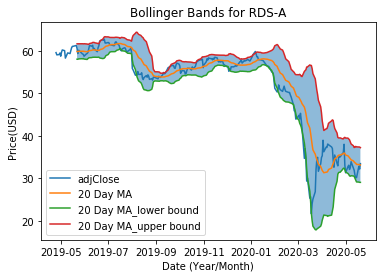

<module 'matplotlib.pyplot' from '/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [7]:
rds = bollinger_bands(df.sort_values(by='date'), 'adjClose')
bb_plot(rds)

## Bollinger Band Strategy

The basic strategy is to buy/sell short if the actual value moves beyond the bands. The assumption is that the stock will return toward the mean. 

Let's test our returns if we follow this strategy. 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


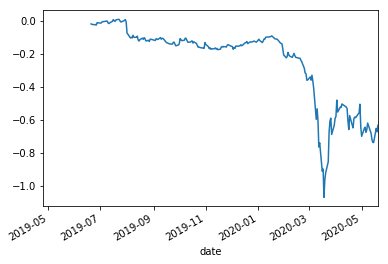

In [8]:
import numpy as np

def bb_strategy(df: pd.DataFrame)->pd.DataFrame:
    """Calculates the returns of implementing the Bollinger Bands 

    :param df: DataFrame

    :return df: df with additional columns for Positing, Market Return, and Strategy Return
    :rtype df: pd.DataFrame
    """
    df['Position'] = None
    #Fill our newly created position column - set to sell (-1) when the price hits the upper band, and set to buy (1) when it hits the lower band
    for row in range(len(df)):
    
        if (df['adjClose'].iloc[row] > df['20 Day MA_upper bound'].iloc[row]) and (df['adjClose'].iloc[row-1] < df['20 Day MA_upper bound'].iloc[row-1]):
            df['Position'].iloc[row] = -1
        
        if (df['adjClose'].iloc[row] < df['20 Day MA_lower bound'].iloc[row]) and (df['adjClose'].iloc[row-1] > df['20 Day MA_lower bound'].iloc[row-1]):
            df['Position'].iloc[row] = 1  

    #Forward fill our position column to replace the "None" values with the correct long/short positions to represent the "holding" of our position
    #forward through time
    df['Position'].fillna(method='ffill',inplace=True)

    #Calculate the daily market return and multiply that by the position to determine strategy returns
    df['Market Return'] = np.log(df['adjClose'] / df['adjClose'].shift(1))
    df['Strategy Return'] = df['Market Return'] * df['Position']
    
    return df

rds = bb_strategy(rds)
rds['Strategy Return'].cumsum().plot() 

## Conclusion
Yikes! Our returns are pretty bad just following the Bollinger Band strategy. We should do more analysis and try another strategy. 

# Exercises: Your Turn!

1. What was the "Open" price of Royal Dutch Shell-A stock (RDS-A) on February 18, 2020?

2. What was the highest volume of RDS-A stock traded in one day?

3. On what day day did this occur?

4. What was RDS-A's biggest one day stock growth in dollar terms? in percentage terms?

5. Create line plot showing RDS-A stock price over time

6. Create line chart showing average monthly stock price of Royal Dutch Shell-A (RDS-A) since January 2019 using 'adjClose.'

hint: df['column'].dt.to_period("M") can convert a date to a month

7. Create same chart but normalize it so that the stock starts at 1 on January 2019

# Extensions

This section lists some ideas for extending the tutorial that you may wish to explore.
* Describe three examples when using APIs for data would be better than downloading data as spreadsheets.

# Further Reading
This section provides more resources on the topic if you are looking to go deeper.

## Books
* Python for Finance, by Yves Hilpisch. http://shop.oreilly.com/product/0636920032441.do
 * [Git Repo](https://github.com/yhilpisch/py4fi2nd)
* Mastering Python for Finance,  James Ma Weiming. https://www.amazon.com/dp/1789346460/
 * [Git Repo](https://github.com/PacktPublishing/Mastering-Python-for-Finance-Second-Edition)
* Python Finance Cookbook, Eryk Lewinson. https://www.packtpub.com/data/python-for-finance-cookbook
 * [Git Repo](https://github.com/erykml/Python-for-Finance-Cookbook)

## APIs
* [Requests library](https://requests.readthedocs.io/en/master/)
    
# Summary

In this tutorial, you were introduced to accessing data using APIs. Specifically, you learned:
* How to access stock data and store it as a Pandas DataFrame
* You did basic analysis using Bollinger Bands and even applied a basic algorithmic trading strategy

# Next

Use the easiest option to get data and then take the data and do amazing analysis.